# Method 9 - Best Ideas High Minus Low Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
low_ideas = best_ideas[best_ideas['size_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['size_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

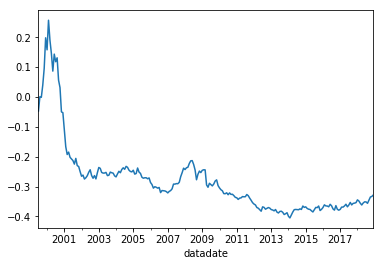

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.197900
2000-12-31   -0.209199
2001-12-31   -0.208422
2002-12-31   -0.005042
2003-12-31   -0.013996
2004-12-31    0.018204
2005-12-31   -0.027065
2006-12-31   -0.062905
2007-12-31    0.114960
2008-12-31   -0.019424
2009-12-31   -0.058384
2010-12-31   -0.055927
2011-12-31   -0.026675
2012-12-31   -0.028525
2013-12-31   -0.024402
2014-12-31    0.029196
2015-12-31   -0.010500
2016-12-31   -0.004515
2017-12-31    0.040752
2018-12-31    0.039448
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     13.74
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.62e-10
Time:                        20:46:59   Log-Likelihood:                 612.07
No. Observations:                 234   AIC:                            -1214.
Df Residuals:                     229   BIC:                            -1197.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -0.833      0.406      -0.003       0.001
mktrf          0.0174      0.033      0.520      0.603      -0.048       0.083
me            -0.0129      0.039     -0.331      0.741      -0.089       0.064
ia            -0.4275      0.059     -7.249      0.000      -0.544      -0.311
roe            0.0958      0.050      1.897      0.059      -0.004       0.195
==============================================================================
Omnibus:                       30.150   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.430
Skew:                          -0.073   Prob(JB):                     1.47e-40
Kurtosis:                       7.335   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     9.295
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.61e-07
Time:                        20:46:59   Log-Likelihood:                 612.07
No. Observations:                 234   AIC:                            -1214.
Df Residuals:                     229   BIC:                            -1197.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -0.710      0.478      -0.004       0.002
mktrf          0.0174      0.043      0.406      0.685      -0.066       0.101
me            -0.0129      0.118     -0.109      0.913      -0.244       0.218
ia            -0.4275      0.145     -2.942      0.003      -0.712      -0.143
roe            0.0958      0.072      1.331      0.183      -0.045       0.237
==============================================================================
Omnibus:                       30.150   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.430
Skew:                          -0.073   Prob(JB):                     1.47e-40
Kurtosis:                       7.335   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     8.792
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.28e-06
Time:                        20:46:59   Log-Likelihood:                 612.07
No. Observations:                 234   AIC:                            -1214.
Df Residuals:                     229   BIC:                            -1197.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -0.719      0.472      -0.004       0.002
mktrf          0.0174      0.036      0.489      0.625      -0.052       0.087
me            -0.0129      0.115     -0.112      0.911      -0.238       0.212
ia            -0.4275      0.162     -2.636      0.008      -0.745      -0.110
roe            0.0958      0.069      1.384      0.166      -0.040       0.231
==============================================================================
Omnibus:                       30.150   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.430
Skew:                          -0.073   Prob(JB):                     1.47e-40
Kurtosis:                       7.335   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     19.33
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.94e-16
Time:                        20:46:59   Log-Likelihood:                 628.25
No. Observations:                 234   AIC:                            -1244.
Df Residuals:                     228   BIC:                            -1224.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.666e-06      0.001      0.008      0.993      -0.002       0.002
mktrf         -0.0199      0.031     -0.637      0.525      -0.081       0.042
smb           -0.1098      0.041     -2.663      0.008      -0.191      -0.029
hml           -0.2724      0.049     -5.601      0.000      -0.368      -0.177
rmw           -0.1418      0.055     -2.579      0.011      -0.250      -0.033
cma            0.0059      0.070      0.084      0.933      -0.132       0.144
==============================================================================
Omnibus:                       27.634   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.702
Skew:                          -0.088   Prob(JB):                     8.45e-33
Kurtosis:                       6.888   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     29.38
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.54e-23
Time:                        20:46:59   Log-Likelihood:                 628.25
No. Observations:                 234   AIC:                            -1244.
Df Residuals:                     228   BIC:                            -1224.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.666e-06      0.001      0.009      0.993      -0.002       0.002
mktrf         -0.0199      0.027     -0.726      0.468      -0.074       0.034
smb           -0.1098      0.083     -1.316      0.188      -0.273       0.054
hml           -0.2724      0.065     -4.205      0.000      -0.399      -0.145
rmw           -0.1418      0.071     -1.985      0.047      -0.282      -0.002
cma            0.0059      0.103      0.057      0.954      -0.195       0.207
==============================================================================
Omnibus:                       27.634   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.702
Skew:                          -0.088   Prob(JB):                     8.45e-33
Kurtosis:                       6.888   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     42.90
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.69e-31
Time:                        20:46:59   Log-Likelihood:                 628.25
No. Observations:                 234   AIC:                            -1244.
Df Residuals:                     228   BIC:                            -1224.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.666e-06      0.001      0.010      0.992      -0.002       0.002
mktrf         -0.0199      0.024     -0.818      0.413      -0.068       0.028
smb           -0.1098      0.071     -1.544      0.123      -0.249       0.030
hml           -0.2724      0.068     -3.992      0.000      -0.406      -0.139
rmw           -0.1418      0.078     -1.824      0.068      -0.294       0.011
cma            0.0059      0.106      0.055      0.956      -0.202       0.214
==============================================================================
Omnibus:                       27.634   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.702
Skew:                          -0.088   Prob(JB):                     8.45e-33
Kurtosis:                       6.888   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     38.15
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.90e-24
Time:                        20:46:59   Log-Likelihood:                 646.64
No. Observations:                 234   AIC:                            -1283.
Df Residuals:                     229   BIC:                            -1266.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.001     -1.723      0.086      -0.004       0.000
mktrf          0.0906      0.026      3.422      0.001       0.038       0.143
smb           -0.0900      0.033     -2.723      0.007      -0.155      -0.025
hml           -0.2904      0.033     -8.840      0.000      -0.355      -0.226
umd            0.1506      0.022      6.988      0.000       0.108       0.193
==============================================================================
Omnibus:                       10.202   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               20.008
Skew:                           0.122   Prob(JB):                     4.52e-05
Kurtosis:                       4.412   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     13.94
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.42e-10
Time:                        20:46:59   Log-Likelihood:                 646.64
No. Observations:                 234   AIC:                            -1283.
Df Residuals:                     229   BIC:                            -1266.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.001     -1.638      0.101      -0.004       0.000
mktrf          0.0906      0.043      2.109      0.035       0.006       0.175
smb           -0.0900      0.072     -1.254      0.210      -0.231       0.051
hml           -0.2904      0.059     -4.902      0.000      -0.407      -0.174
umd            0.1506      0.040      3.811      0.000       0.073       0.228
==============================================================================
Omnibus:                       10.202   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               20.008
Skew:                           0.122   Prob(JB):                     4.52e-05
Kurtosis:                       4.412   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     11.54
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.50e-08
Time:                        20:46:59   Log-Likelihood:                 646.64
No. Observations:                 234   AIC:                            -1283.
Df Residuals:                     229   BIC:                            -1266.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.001     -1.518      0.129      -0.004       0.001
mktrf          0.0906      0.049      1.842      0.065      -0.006       0.187
smb           -0.0900      0.061     -1.472      0.141      -0.210       0.030
hml           -0.2904      0.069     -4.236      0.000      -0.425      -0.156
umd            0.1506      0.046      3.305      0.001       0.061       0.240
==============================================================================
Omnibus:                       10.202   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               20.008
Skew:                           0.122   Prob(JB):                     4.52e-05
Kurtosis:                       4.412   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     10.43
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.03e-07
Time:                        20:46:59   Log-Likelihood:                 287.59
No. Observations:                 120   AIC:                            -565.2
Df Residuals:                     115   BIC:                            -551.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.002     -0.878      0.382      -0.006       0.002
mktrf          0.0417      0.058      0.718      0.474      -0.073       0.157
me             0.0726      0.057      1.267      0.208      -0.041       0.186
ia            -0.5497      0.090     -6.129      0.000      -0.727      -0.372
roe            0.1609      0.079      2.026      0.045       0.004       0.318
==============================================================================
Omnibus:                       10.527   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               18.428
Skew:                          -0.346   Prob(JB):                     9.96e-05
Kurtosis:                       4.791   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     6.213
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000146
Time:                        20:46:59   Log-Likelihood:                 287.59
No. Observations:                 120   AIC:                            -565.2
Df Residuals:                     115   BIC:                            -551.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.003     -0.719      0.472      -0.007       0.003
mktrf          0.0417      0.075      0.558      0.577      -0.105       0.188
me             0.0726      0.124      0.583      0.560      -0.171       0.316
ia            -0.5497      0.168     -3.275      0.001      -0.879      -0.221
roe            0.1609      0.110      1.466      0.143      -0.054       0.376
==============================================================================
Omnibus:                       10.527   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               18.428
Skew:                          -0.346   Prob(JB):                     9.96e-05
Kurtosis:                       4.791   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     5.885
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000241
Time:                        20:46:59   Log-Likelihood:                 287.59
No. Observations:                 120   AIC:                            -565.2
Df Residuals:                     115   BIC:                            -551.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.003     -0.701      0.483      -0.007       0.003
mktrf          0.0417      0.074      0.566      0.571      -0.103       0.186
me             0.0726      0.126      0.578      0.563      -0.174       0.319
ia            -0.5497      0.186     -2.962      0.003      -0.913      -0.186
roe            0.1609      0.110      1.460      0.144      -0.055       0.377
==============================================================================
Omnibus:                       10.527   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               18.428
Skew:                          -0.346   Prob(JB):                     9.96e-05
Kurtosis:                       4.791   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     12.62
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.30e-10
Time:                        20:47:00   Log-Likelihood:                 295.44
No. Observations:                 120   AIC:                            -578.9
Df Residuals:                     114   BIC:                            -562.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.002      0.062      0.951      -0.004       0.004
mktrf         -0.0295      0.058     -0.512      0.609      -0.143       0.084
smb           -0.0597      0.065     -0.917      0.361      -0.189       0.069
hml           -0.3213      0.080     -4.024      0.000      -0.479      -0.163
rmw           -0.1227      0.094     -1.303      0.195      -0.309       0.064
cma           -0.0332      0.103     -0.322      0.748      -0.238       0.171
==============================================================================
Omnibus:                       14.982   Durbin-Watson:                   2.360
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               29.965
Skew:                          -0.486   Prob(JB):                     3.11e-07
Kurtosis:                       5.247   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     17.55
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.38e-13
Time:                        20:47:00   Log-Likelihood:                 295.44
No. Observations:                 120   AIC:                            -578.9
Df Residuals:                     114   BIC:                            -562.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.002      0.071      0.943      -0.003       0.004
mktrf         -0.0295      0.049     -0.607      0.544      -0.125       0.066
smb           -0.0597      0.105     -0.568      0.570      -0.266       0.146
hml           -0.3213      0.083     -3.863      0.000      -0.484      -0.158
rmw           -0.1227      0.081     -1.523      0.128      -0.281       0.035
cma           -0.0332      0.145     -0.229      0.819      -0.318       0.251
==============================================================================
Omnibus:                       14.982   Durbin-Watson:                   2.360
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               29.965
Skew:                          -0.486   Prob(JB):                     3.11e-07
Kurtosis:                       5.247   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     28.69
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.71e-19
Time:                        20:47:00   Log-Likelihood:                 295.44
No. Observations:                 120   AIC:                            -578.9
Df Residuals:                     114   BIC:                            -562.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.002      0.076      0.940      -0.003       0.003
mktrf         -0.0295      0.047     -0.623      0.534      -0.122       0.063
smb           -0.0597      0.087     -0.685      0.493      -0.231       0.111
hml           -0.3213      0.084     -3.844      0.000      -0.485      -0.157
rmw           -0.1227      0.076     -1.619      0.105      -0.271       0.026
cma           -0.0332      0.154     -0.216      0.829      -0.335       0.268
==============================================================================
Omnibus:                       14.982   Durbin-Watson:                   2.360
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               29.965
Skew:                          -0.486   Prob(JB):                     3.11e-07
Kurtosis:                       5.247   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     37.03
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.17e-20
Time:                        20:47:00   Log-Likelihood:                 318.67
No. Observations:                 120   AIC:                            -627.3
Df Residuals:                     115   BIC:                            -613.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.002     -0.897      0.372      -0.005       0.002
mktrf          0.1618      0.039      4.104      0.000       0.084       0.240
smb           -0.0970      0.045     -2.159      0.033      -0.186      -0.008
hml           -0.3535      0.045     -7.861      0.000      -0.443      -0.264
umd            0.2096      0.028      7.558      0.000       0.155       0.264
==============================================================================
Omnibus:                        0.361   Durbin-Watson:                   2.310
Prob(Omnibus):                  0.835   Jarque-Bera (JB):                0.391
Skew:                          -0.128   Prob(JB):                        0.822
Kurtosis:                       2.886   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     13.32
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.96e-09
Time:                        20:47:00   Log-Likelihood:                 318.67
No. Observations:                 120   AIC:                            -627.3
Df Residuals:                     115   BIC:                            -613.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.116      0.264      -0.004       0.001
mktrf          0.1618      0.050      3.214      0.001       0.063       0.261
smb           -0.0970      0.071     -1.360      0.174      -0.237       0.043
hml           -0.3535      0.053     -6.716      0.000      -0.457      -0.250
umd            0.2096      0.039      5.409      0.000       0.134       0.285
==============================================================================
Omnibus:                        0.361   Durbin-Watson:                   2.310
Prob(Omnibus):                  0.835   Jarque-Bera (JB):                0.391
Skew:                          -0.128   Prob(JB):                        0.822
Kurtosis:                       2.886   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     9.810
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.29e-07
Time:                        20:47:00   Log-Likelihood:                 318.67
No. Observations:                 120   AIC:                            -627.3
Df Residuals:                     115   BIC:                            -613.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.033      0.302      -0.004       0.001
mktrf          0.1618      0.053      3.038      0.002       0.057       0.266
smb           -0.0970      0.061     -1.585      0.113      -0.217       0.023
hml           -0.3535      0.057     -6.199      0.000      -0.465      -0.242
umd            0.2096      0.044      4.710      0.000       0.122       0.297
==============================================================================
Omnibus:                        0.361   Durbin-Watson:                   2.310
Prob(Omnibus):                  0.835   Jarque-Bera (JB):                0.391
Skew:                          -0.128   Prob(JB):                        0.822
Kurtosis:                       2.886   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     20.17
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.88e-12
Time:                        20:47:00   Log-Likelihood:                 395.63
No. Observations:                 114   AIC:                            -781.3
Df Residuals:                     109   BIC:                            -767.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.975      0.332      -0.002       0.001
mktrf          0.0274      0.023      1.210      0.229      -0.017       0.072
me            -0.2387      0.035     -6.831      0.000      -0.308      -0.169
ia            -0.0513      0.048     -1.059      0.292      -0.147       0.045
roe            0.1086      0.043      2.551      0.012       0.024       0.193
==============================================================================
Omnibus:                        4.417   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                3.828
Skew:                           0.422   Prob(JB):                        0.147
Kurtosis:                       3.308   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     26.84
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.67e-15
Time:                        20:47:00   Log-Likelihood:                 395.63
No. Observations:                 114   AIC:                            -781.3
Df Residuals:                     109   BIC:                            -767.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -1.023      0.306      -0.002       0.001
mktrf          0.0274      0.017      1.632      0.103      -0.005       0.060
me            -0.2387      0.031     -7.728      0.000      -0.299      -0.178
ia            -0.0513      0.055     -0.939      0.348      -0.158       0.056
roe            0.1086      0.033      3.318      0.001       0.044       0.173
==============================================================================
Omnibus:                        4.417   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                3.828
Skew:                           0.422   Prob(JB):                        0.147
Kurtosis:                       3.308   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     36.97
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.66e-19
Time:                        20:47:00   Log-Likelihood:                 395.63
No. Observations:                 114   AIC:                            -781.3
Df Residuals:                     109   BIC:                            -767.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -1.043      0.297      -0.002       0.001
mktrf          0.0274      0.014      1.927      0.054      -0.000       0.055
me            -0.2387      0.029     -8.133      0.000      -0.296      -0.181
ia            -0.0513      0.059     -0.870      0.384      -0.167       0.064
roe            0.1086      0.030      3.592      0.000       0.049       0.168
==============================================================================
Omnibus:                        4.417   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                3.828
Skew:                           0.422   Prob(JB):                        0.147
Kurtosis:                       3.308   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     17.78
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.99e-13
Time:                        20:47:00   Log-Likelihood:                 398.28
No. Observations:                 114   AIC:                            -784.6
Df Residuals:                     108   BIC:                            -768.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -1.012      0.314      -0.002       0.001
mktrf          0.0140      0.021      0.661      0.510      -0.028       0.056
smb           -0.2185      0.034     -6.353      0.000      -0.287      -0.150
hml           -0.0349      0.044     -0.797      0.427      -0.122       0.052
rmw            0.1613      0.054      3.004      0.003       0.055       0.268
cma            0.0182      0.068      0.267      0.790      -0.117       0.153
==============================================================================
Omnibus:                        2.616   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.270   Jarque-Bera (JB):                2.038
Skew:                           0.282   Prob(JB):                        0.361
Kurtosis:                       3.333   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     34.32
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.43e-21
Time:                        20:47:00   Log-Likelihood:                 398.28
No. Observations:                 114   AIC:                            -784.6
Df Residuals:                     108   BIC:                            -768.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.985      0.325      -0.002       0.001
mktrf          0.0140      0.015      0.944      0.345      -0.015       0.043
smb           -0.2185      0.034     -6.431      0.000      -0.285      -0.152
hml           -0.0349      0.045     -0.769      0.442      -0.124       0.054
rmw            0.1613      0.045      3.613      0.000       0.074       0.249
cma            0.0182      0.089      0.203      0.839      -0.157       0.193
==============================================================================
Omnibus:                        2.616   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.270   Jarque-Bera (JB):                2.038
Skew:                           0.282   Prob(JB):                        0.361
Kurtosis:                       3.333   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     38.37
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.81e-22
Time:                        20:47:00   Log-Likelihood:                 398.28
No. Observations:                 114   AIC:                            -784.6
Df Residuals:                     108   BIC:                            -768.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.950      0.342      -0.002       0.001
mktrf          0.0140      0.012      1.202      0.229      -0.009       0.037
smb           -0.2185      0.033     -6.528      0.000      -0.284      -0.153
hml           -0.0349      0.041     -0.848      0.396      -0.116       0.046
rmw            0.1613      0.043      3.716      0.000       0.076       0.246
cma            0.0182      0.089      0.204      0.838      -0.156       0.193
==============================================================================
Omnibus:                        2.616   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.270   Jarque-Bera (JB):                2.038
Skew:                           0.282   Prob(JB):                        0.361
Kurtosis:                       3.333   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     18.80
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.83e-12
Time:                        20:47:00   Log-Likelihood:                 393.96
No. Observations:                 114   AIC:                            -777.9
Df Residuals:                     109   BIC:                            -764.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.417      0.678      -0.002       0.001
mktrf         -0.0016      0.022     -0.072      0.942      -0.045       0.042
smb           -0.2535      0.034     -7.472      0.000      -0.321      -0.186
hml           -0.0777      0.035     -2.224      0.028      -0.147      -0.008
umd           -0.0182      0.026     -0.691      0.491      -0.070       0.034
==============================================================================
Omnibus:                        3.310   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.191   Jarque-Bera (JB):                2.798
Skew:                           0.370   Prob(JB):                        0.247
Kurtosis:                       3.205   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     36.42
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.62e-19
Time:                        20:47:00   Log-Likelihood:                 393.96
No. Observations:                 114   AIC:                            -777.9
Df Residuals:                     109   BIC:                            -764.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.434      0.664      -0.002       0.001
mktrf         -0.0016      0.018     -0.090      0.928      -0.036       0.033
smb           -0.2535      0.034     -7.423      0.000      -0.320      -0.187
hml           -0.0777      0.028     -2.808      0.005      -0.132      -0.023
umd           -0.0182      0.023     -0.777      0.437      -0.064       0.028
==============================================================================
Omnibus:                        3.310   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.191   Jarque-Bera (JB):                2.798
Skew:                           0.370   Prob(JB):                        0.247
Kurtosis:                       3.205   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     33.65
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.88e-18
Time:                        20:47:00   Log-Likelihood:                 393.96
No. Observations:                 114   AIC:                            -777.9
Df Residuals:                     109   BIC:                            -764.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.423      0.672      -0.002       0.001
mktrf         -0.0016      0.016     -0.097      0.923      -0.033       0.030
smb           -0.2535      0.032     -7.899      0.000      -0.316      -0.191
hml           -0.0777      0.026     -2.994      0.003      -0.129      -0.027
umd           -0.0182      0.017     -1.072      0.284      -0.052       0.015
==============================================================================
Omnibus:                        3.310   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.191   Jarque-Bera (JB):                2.798
Skew:                           0.370   Prob(JB):                        0.247
Kurtosis:                       3.205   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""